## Model Training and Evaulation
#### First we need to reload our metadata files and Pytorch DataSets

In [ ]:
import os
import time
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
import pandas as pd
from torchvision import models
import torch.nn as nn

# ***** Setup your working dir & csv file here *****
os.chdir('C:\\Users\\Robin\\Desktop\\2019')

n_class = 8 #set number of classes to predict

In [ ]:
# define Pytorch Dataset structure
# official documentation at https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
# Basically, this is just a collection of functions that pulls up an image file iteratively
# For example if i=55, this will pull the filename of the image from the 55th row of the metadata file
# Overall, prevents the entire dataset from having to be read into memory

import torch
from torchvision.transforms import transforms, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from scipy import ndimage
import numpy as np
from PIL import Image

class ImageDataset(Dataset):
  def __init__(self, datadir, dataframe, transforms = None):
    super().__init__()
    self.datadir = str(datadir) #assigns user inputed data dir
    self.df = dataframe #assigns metadata df to class object 
    self.transform = transforms #assigns desired transforms to class object

  def __len__(self):
    return(self.df.shape[0]) #overrides base len() func call to return number of images

  def labels(self):
    labels = self.df['dx'].unique() #returns string label for each 'dx' class
    labels = sorted(labels)
    return 
    
  def description(self):
      return self.df['dx'].value_counts() #returns number of images for each 'dx' class

  def __getitem__(self, idx):
    labels = dict(zip(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'scc', 'vasc'], range(n_class))) #assigns dx to integer coded value to be used as index later
    row = self.df.iloc[idx] #selects nth row from metadata
    image = row['image_id'] #selects image filename from selected row
    label_one_hot = np.zeros(n_class).astype(int) #vector of n_class zeros
    label_one_hot[labels[row['dx']]] = 1 #inserts value of 1 at index corresponding to above integer coded value
    image = Image.open((self.datadir + image + '.jpg'))

    if self.transform:
      image = self.transform(image)

    return image, torch.tensor(label_one_hot) #call image data from appropriate tensor index

In [ ]:
# Load metadata files created in the dataprep stage
training_meta = pd.read_csv('training_metadata.csv')
validation_meta = pd.read_csv('validation_metadata.csv')

# Define image transforms; Resize to 224x224 to fit ResNet18 backbone
# Convert each image into tensor; normalize values are recommended mean/std based on ImageNet
transfx = transforms.Compose([Resize((224,224)), ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Initialize new Pytorch Dataset for train/valid splits; print total number of images for each to confirm loading
train_ds = ImageDataset('.\\all_imgs\\', training_meta, transfx) # ***** first arg needs to refect the filepath of where images are *****
valid_ds = ImageDataset('.\\all_imgs\\', validation_meta, transfx) # ***** first arg needs to refect the filepath of where images are *****
len(train_ds), len(valid_ds)

In [ ]:
# Set up Pytorch loaders for training and validation; reduce batch size or num_workers if memory is an issue
train_loader = DataLoader(train_ds, batch_size = 64, shuffle= True, num_workers = 0)
valid_loader = DataLoader(valid_ds, batch_size = 64, shuffle= True, num_workers = 0)

#### Load in Model Pre-trained CNN and Adapt for Custom Dataset

In [ ]:
# Import pre-trained ResNet18 with ImageNet weights
net = models.resnet18(pretrained=True)

# Add freah fully connected classifier layer
net.fc = nn.Sequential(
                      nn.Linear(512, 256), # add a fully connected layer with 512 input; output 256 features
                      nn.ReLU(), # ReLU activation
                      nn.Dropout(0.4), # dropout some nodes to counter overfitting
                      nn.Linear(256, n_class), # another fully connected layer to end up with output = classes
                      nn.LogSoftmax(dim=1) # can also just use softmax if don't want to convert to probabilites later
                      )

# Choose Which CovNet layers to re-train
# Will retrain weights for the top CovNet (layer 4)
# Also need to train the FC layer we just added
for param in net.conv1.parameters():
  param.requires_grad = False

for param in net.layer1.parameters():
  param.requires_grad = False

for param in net.layer2.parameters():
  param.requires_grad = False

for param in net.layer3.parameters():
  param.requires_grad = False

for param in net.layer4.parameters():
  param.requires_grad = True

for param in net.fc.parameters():
  param.requires_grad = True

net = net.cuda() #recommend running on GPU, very slow on CPU

In [ ]:
# Define our loss function
criterion = nn.CrossEntropyLoss()

# Define our validation loop so we can characterize validation loss as we train
def validation():
  loss = 0.0
  print('Validating...')
  with torch.no_grad():
    net.eval() #set model for forward prop only
    total_count, true_count, i = 0, 0, 0
    for valid_data, valid_label in tqdm(valid_loader): #iterate thru each validation image
      i += 1
      output = net(valid_data.cuda())
      val_targets = torch.argmax(valid_label.cuda(),1) #convert one-hot labels to class indicies
      loss += criterion(output, val_targets.cuda())
      avg_val_loss= loss/i
      for pred, target in zip(output, val_targets.cuda()):
        total_count += 1
        if(torch.argmax(pred) == target):
          true_count += 1
    correct = (true_count * 100)/ total_count
    val_losses.append(avg_val_loss)
    return avg_val_loss, correct

# Apply ADAM optimization function for each layer that we decided to (re)train
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()),
                       lr = 0.00005,
                       weight_decay = 1e-5) #set L2 reg here to counter overfitting, default 1e-5

# Set length of training
patience = 5
n_epoch = 20

# Initialize these to track loss over each epoch
train_losses = []
val_losses = []

# Setup main loop for training
for epoch in range(1, (n_epoch+1)):
  ts = time.localtime()
  start_time = time.strftime("%H:%M:%S", ts)
  print(f'\nEpoch {epoch} Start: {start_time}')
  print('Training...')
  net.train()
  totalloss = 0
  i = 0
  for train_data, train_label in tqdm(train_loader):
    optimizer.zero_grad()
    output = net(train_data.cuda())
    train_targets = torch.argmax(train_label.cuda(),1) #convert one-hot labels to class indicies
    loss = criterion(output, train_targets.cuda())
    totalloss += loss
    i +=1
    avgloss = totalloss/i
    total_count, true_count = 0, 0
    for pred, target in zip(output, train_targets.cuda()):
      total_count += 1
      if(torch.argmax(pred) == target):
        true_count += 1
    train_acc = (true_count * 100)/ total_count
    loss.backward()
    optimizer.step()
  train_losses.append(avgloss)
  valloss, valid_acc = validation()
  te = time.localtime()
  end_time = time.strftime("%H:%M:%S", te)
  print(f'Epoch {epoch} End: {end_time}')
  print(f'Training Loss: {avgloss}; Training Accuracy: {train_acc}%\nValidation Loss: {valloss}; Validation Accuracy: {valid_acc}%')
  print('\n')
  print(f'Saving Checkpoint for Epoch {epoch}!\n')
  torch.save(net.state_dict(), 'checkpoint_e{}_Vacc_{}.pt'.format(epoch, round(valid_acc,3))) #save model after each epoch
  print('\n')
  try:
    if(val_losses[-1] >= val_losses[-2]):
      print(f'Early Stopping Triggered -- Patience Remaining: {patience-1}')
      patience -= 1
      if patience <= 0:
        break
  except:
    pass

## Validation & Metrics
#### Okay, now that we've trained for a bit, let's see how the validation accuracy actually breaks down per class

In [ ]:
# Reload model checkpoint. Might as well reload even if evaluating final epoch so we can turn off CUDA
saved_model = 'checkpoint_e6_Vacc_72.162.pt'

# Load in backbone; this should match model definition above
net = models.resnet18(pretrained=False)

net.fc = nn.Sequential(nn.Linear(512, 256),
                       nn.ReLU(),
                       nn.Dropout(0.4),
                       nn.Linear(256, n_class),
                       nn.LogSoftmax(dim=1)) 
checkpoint = torch.load(saved_model, map_location=torch.device('cpu')) #change dev to 'cpu' for portable deployment
net.load_state_dict(checkpoint)


# Generate predictions for entire validation dataset
from tqdm import tqdm_notebook as tqdm

def make_preds(net):
  all_samples = DataLoader(valid_ds, batch_size = 1, shuffle = False, num_workers = 0) #batch size must be 1 or else our output has odd shape
  confmatrix = []
  preds_stack = []
  with torch.no_grad():
    net.eval()
    for batches, labels in tqdm(all_samples):
      preds = net(batches)
      preds_stack.append(preds)
      preds = torch.argmax(preds,1)
      actual = torch.argmax(labels,1)
      stack = torch.stack((preds, actual), dim=1)
      confmatrix += stack.tolist()
          
  return confmatrix, preds_stack

conf_stack, preds_stack = make_preds(net)

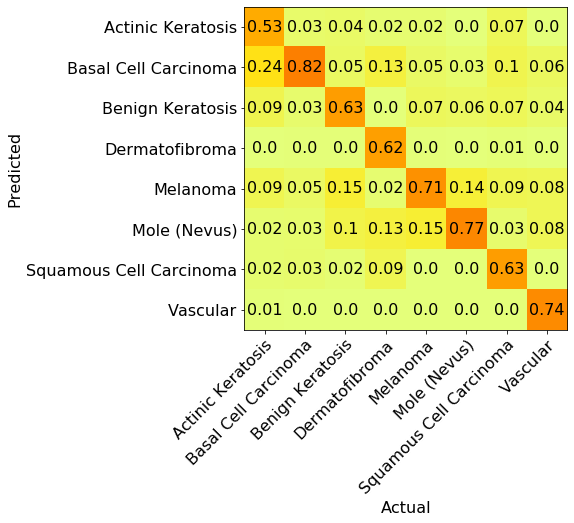

In [18]:
# Put output/actual pairs into an numpy array
conf_matrix = np.zeros((n_class,n_class), dtype= int)
for pair in conf_stack:
    x, y = pair
    conf_matrix[x, y] = conf_matrix[x, y] + 1

totals_c = np.sum(conf_matrix, axis=0)
totals_r = np.sum(conf_matrix, axis=1)

# Plot a heatmap of the confusion matrix

labels_dict = {0: 'Actinic Keratosis',
 1: 'Basal Cell Carcinoma',
 2: 'Benign Keratosis',
 3: 'Dermatofibroma',
 4: 'Melanoma',
 5: 'Mole (Nevus)',
 6: 'Squamous Cell Carcinoma',              
 7: 'Vascular'}

# convert counts to proportion of total
proportions = conf_matrix/totals_c

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(proportions, cmap = 'Wistia')

ax.set_xticks(range(n_class))
ax.set_yticks(range(n_class))

ax.set_xticklabels([labels_dict[i] for i in range(n_class)], fontsize = 16)
ax.set_yticklabels([labels_dict[i] for i in range(n_class)], fontsize = 16)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(n_class):
    for j in range(n_class):
        text = ax.text(j, i, round(proportions[i, j],2),
                       ha="center", va="center", color="black", fontsize = 16)

ax.set_ylabel("Predicted", fontsize = 16)
ax.set_xlabel("Actual", fontsize = 16)
ax.set_ylim(n_class-0.5, -0.5)
fig.tight_layout()
plt.show()

#### The confusion matrix shows that the model is doing a decent job overall at classifiying the different types of skin lesions in the validation data. Some classes perform better than others so let's compute some metrics to reflect this.

#### Some ROC curves for each class...

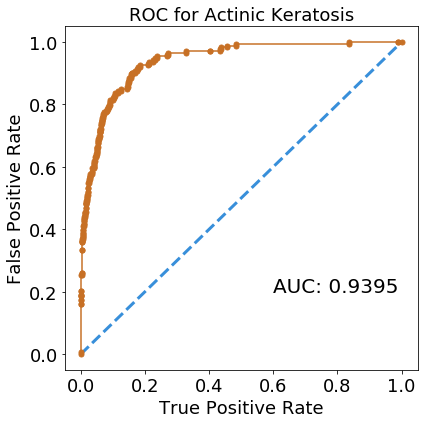

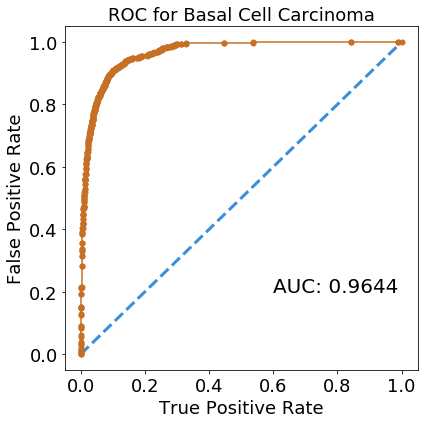

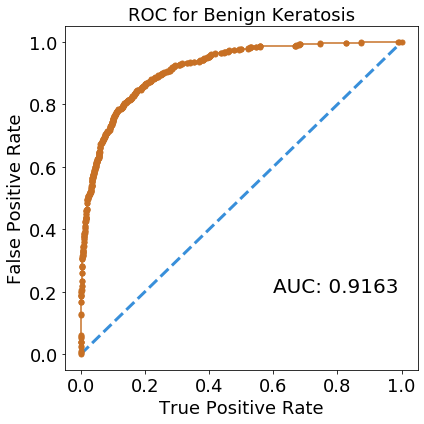

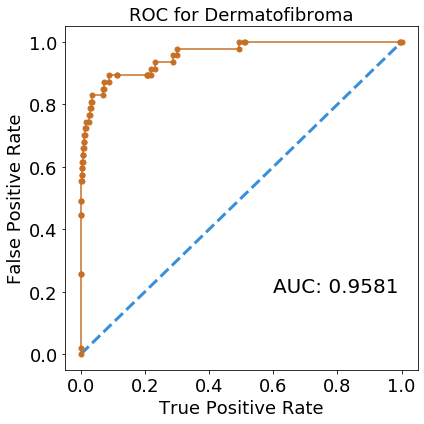

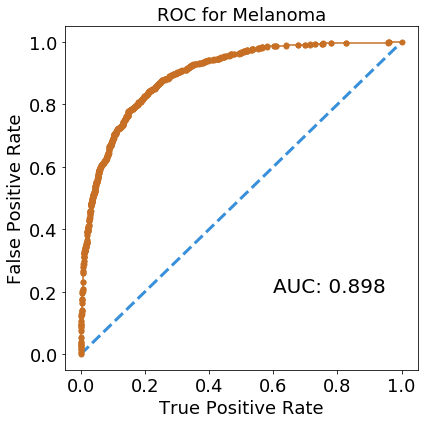

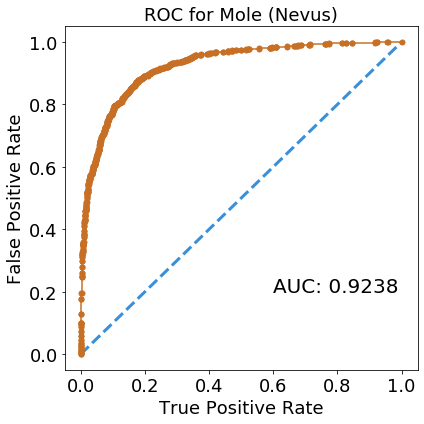

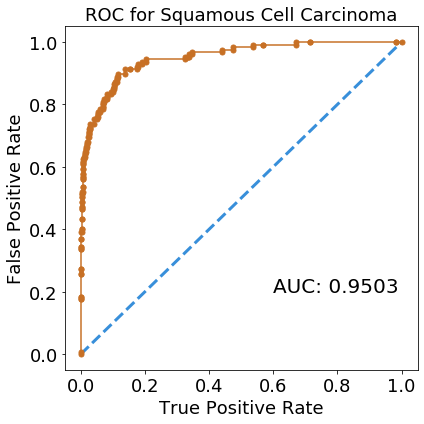

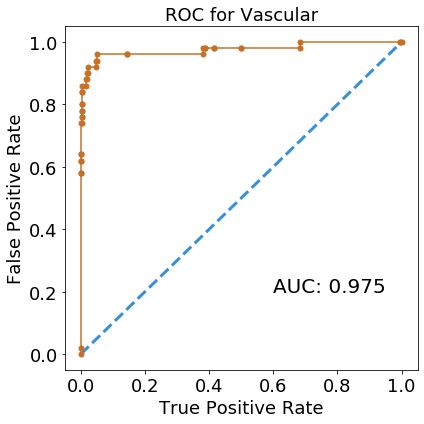

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Process & reshape model output to work with sklearn funcs
# Some of the outputs are in Tensors with wonky shapes, etc
probs_array = [preds_stack[tensor].numpy() for tensor in range(len(preds_stack))]
probs3d = np.stack(probs_array, axis=0)
probs2d = probs3d.transpose(1,0,2).reshape(len(probs3d),n_class)
probs2d = np.exp(probs2d)

actuals = np.array(conf_stack)
actuals = actuals[:,1]
preds = np.array(conf_stack)
preds = preds[:,0]

actuals2d = []
for i in range(n_class):
  tmp = []
  for r in range(len(actuals)):
    if actuals[r] == i:
      tmp.append(1)
    else:
      tmp.append(0)
  actuals2d.append(tmp)

actuals2d = np.array(actuals2d)
actuals2d = actuals2d.transpose(1,0)

preds2d = []
for i in range(n_class):
  tmp = []
  for r in range(len(preds)):
    if preds[r] == i:
      tmp.append(1)
    else:
      tmp.append(0)
  preds2d.append(tmp)

preds2d = np.array(preds2d)
preds2d = preds2d.transpose(1,0)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_class):
    fpr[i], tpr[i], _ = roc_curve(actuals2d[:,i], probs2d[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(actuals2d.ravel(), preds2d.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotting func
def plot_roc(coi):
  fig, ax = plt.subplots(figsize=(6,6))
  ax.plot([0,1], [0,1], linestyle='--', color='#388FDA', linewidth=3)
  ax.plot(fpr[coi], tpr[coi], marker='.', color='#C77025', markersize=10)
  ax.tick_params(axis='both', which='major', labelsize=18)
  ax.tick_params(axis='both', which='minor', labelsize=18)
  ax.set_ylabel('False Positive Rate', fontsize=18)
  ax.set_xlabel('True Positive Rate', fontsize=18)
  ax.text(0.6, 0.2,('AUC: ' + str(round(roc_auc[coi],4))), fontsize=20)
  ax.set_title('ROC for '+ labels_dict[coi], fontsize=18)
  fig.tight_layout()
  plt.show()

# Plot ROC for each class OvR
for i in range(n_class):
    plot_roc(i)

#### Precision/Recall Curve...

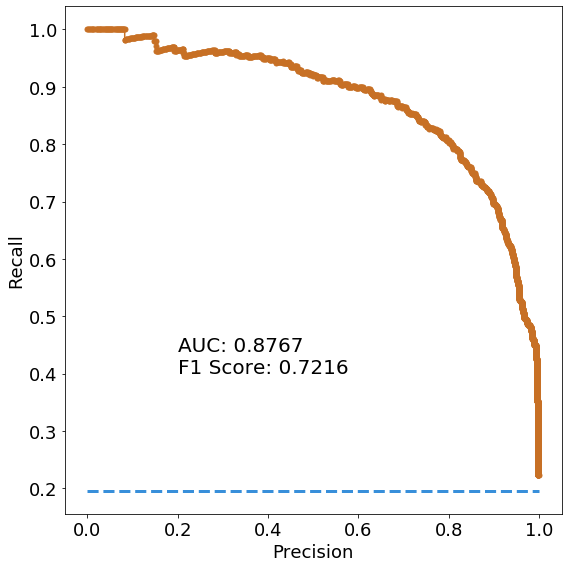

In [20]:
# Calc PR Curve & Micro F1 Score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

precision, recall, _ = precision_recall_curve(actuals2d[:,1], probs2d[:,1], pos_label=1)
cx_f1, cx_auc = f1_score(actuals2d, preds2d, average='micro'), auc(recall, precision)
no_skill = len(actuals[actuals==1]) / len(actuals)

# Plotting
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,8))
ax.plot([0, 1], [no_skill, no_skill], linestyle='--', color='#388FDA', linewidth=3)
ax.plot(recall, precision, marker='.', color='#C77025', markersize=10)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.set_ylabel('Recall', fontsize=18)
ax.set_xlabel('Precision', fontsize=18)

#Augment placement of AUC & F1 Score Text Here
text_x = 0.2
text_y = 0.4

ax.text(text_x, text_y,('AUC: ' + str(round(cx_auc,4))) + '\nF1 Score: ' + str(round(cx_f1,4)), fontsize=20)
fig.tight_layout()
#fig.savefig(RPCfig, dpi=150, bbox_inches='tight')
plt.show()

#### Based on the micro F1 Score, the model has an overall accuracy of 72.2% over all classes. Let's figure out what the baseline accuracy we'd expect from random chance would be:

In [21]:
# Figure out baseline performance with DummyClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

class_info = valid_ds.description()

twoD_vals = []
class_labs = []

for i in range(len(class_info.keys())):
    for j in range(class_info[i]):
        twoD_vals.append( [i,i] )
        class_labs.append(i)

x = np.array(twoD_vals)
y = np.array(class_labs)

classifier = DummyClassifier(strategy="stratified")
classifier.fit(x,y)
dummy_preds = classifier.predict(twoD_vals)
dummy_probs = classifier.predict_proba(twoD_vals)

accuracy_score(class_labs, dummy_preds)

0.22205838985549986

#### So, if we were to randomly assign our class predictions, taking into account the total number of images from each class in our validation split, we'd expect 22.2% overall accuracy. Fair to say our model is performing well over baseline!